In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

# Exercises
file name: time_series_anomaly_detection.py or time_series_anomaly_detection.ipynb

## Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

In [2]:
data = pd.read_csv('anonymized-curriculum-access.txt', sep=" ", header=None)

In [3]:
data.head()

,0,1,2,3,4,5
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [4]:
df = pd.read_fwf('anonymized-curriculum-access.txt')

In [5]:
data['date'] = data[0] + ' ' + data[1]

In [6]:
df.head()

,2018-01-26,09:55:03,/ 1 8 97.105.19.61,Unnamed: 3
0,2018-01-26,09:56:02,java-ii 1 8 97.105.19.61,NaN
1,2018-01-26,09:56:05,java-ii/object-oriented-programming 1 8 97.105...,NaN
2,2018-01-26,09:56:06,slides/object_oriented_programming 1 8 97.105....,NaN
3,2018-01-26,09:56:24,javascript-i/conditionals 2 22 97.105.19.61,NaN
4,2018-01-26,09:56:41,javascript-i/loops 2 22 97.105.19.61,NaN


In [7]:
data = data.drop(columns = [0,1])

In [8]:
data.head()

,2,3,4,5,date
0,/,1,8.0,97.105.19.61,2018-01-26 09:55:03
1,java-ii,1,8.0,97.105.19.61,2018-01-26 09:56:02
2,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018-01-26 09:56:05
3,slides/object_oriented_programming,1,8.0,97.105.19.61,2018-01-26 09:56:06
4,javascript-i/conditionals,2,22.0,97.105.19.61,2018-01-26 09:56:24


In [9]:
data = data.rename(columns={2: "page", 3:'user_id', 4:'cohort_id', 5:'ip'})

In [10]:
data.head()

,page,user_id,cohort_id,ip,date
0,/,1,8.0,97.105.19.61,2018-01-26 09:55:03
1,java-ii,1,8.0,97.105.19.61,2018-01-26 09:56:02
2,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018-01-26 09:56:05
3,slides/object_oriented_programming,1,8.0,97.105.19.61,2018-01-26 09:56:06
4,javascript-i/conditionals,2,22.0,97.105.19.61,2018-01-26 09:56:24


In [11]:
data.date = pd.to_datetime(data.date)
df = data.set_index('date')

In [12]:
df.value_counts()

page                             user_id  cohort_id  ip            
/                                11       28.0       97.105.19.58      571
index.html                       53       14.0       97.105.19.58      501
toc                              632      57.0       136.50.74.48      377
index.html                       53       28.0       67.10.174.56      351
/                                1        28.0       97.105.19.58      345
                                                                      ... 
java-iii/jdbc                    634      57.0       104.190.242.24      1
                                 637      57.0       192.119.10.210      1
                                 648      56.0       76.187.53.87        1
                                 656      58.0       24.9.177.142        1
%20https://github.com/RaulCPena  580      55.0       74.192.167.159      1
Length: 148229, dtype: int64

In [13]:
len(df.ip.value_counts())

4339

In [14]:
len(df.cohort_id.value_counts())

40

In [15]:
len(df.user_id.value_counts())

787

In [16]:
df.groupby(['user_id','ip']).count()

page  cohort_id
user_id ip                             
1       12.5.63.210        6          6
        172.56.15.15       8          8
        172.56.15.203      3          3
        172.56.15.46       1          1
        172.56.15.50       2          2
...                      ...        ...
784     99.43.143.116     93         93
785     24.173.208.242     1          1
        72.181.127.233    30         30
786     72.190.25.232      7          7
787     99.126.113.140     1          1

[6182 rows x 2 columns]

In [17]:
df.groupby(['cohort_id','ip']).count()

page  user_id
cohort_id ip                           
1.0       107.204.49.22      1        1
          107.77.196.213     9        9
          107.77.217.196     3        3
          107.77.217.65      7        7
          107.77.220.6       1        1
...                        ...      ...
62.0      98.199.170.30      2        2
          98.39.66.72       24       24
          99.151.201.25    254      254
          99.162.243.68    126      126
          99.5.223.96        4        4

[4605 rows x 2 columns]

In [18]:
df.groupby(['page','ip']).count()

user_id  cohort_id
page                             ip                                
%20https://github.com/RaulCPena  74.192.167.159        1          1
,%20https://github.com/RaulCPena 74.192.167.159        1          1
.git                             72.178.123.71         1          1
.gitignore                       72.178.123.71         1          1
.well-known/assetlinks.json      70.240.251.44         2          2
...                                                  ...        ...
working-with-time-series-data    72.181.127.233        4          4
                                 75.1.166.163          1          1
                                 96.8.130.213          2          2
wp-admin                         70.121.163.5          1          1
wp-login                         70.121.163.5          1          1

[90364 rows x 2 columns]

In [19]:
df.groupby(['page','cohort_id']).count()

user_id  ip
page                             cohort_id             
%20https://github.com/RaulCPena  55.0             1   1
,%20https://github.com/RaulCPena 55.0             1   1
.git                             24.0             1   1
.gitignore                       24.0             1   1
.well-known/assetlinks.json      58.0             2   2
...                                             ...  ..
web-dev-day-two                  61.0             2   2
working-with-time-series-data    28.0             1   1
                                 59.0            14  14
wp-admin                         22.0             1   1
wp-login                         22.0             1   1

[11780 rows x 2 columns]

In [20]:
df.head()

,page,user_id,cohort_id,ip
date,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [21]:
cohort_df = df.drop(columns = ['user_id','ip'])

In [22]:
cohort_df.head()

,page,cohort_id
date,,
2018-01-26 09:55:03,/,8.0
2018-01-26 09:56:02,java-ii,8.0
2018-01-26 09:56:05,java-ii/object-oriented-programming,8.0
2018-01-26 09:56:06,slides/object_oriented_programming,8.0
2018-01-26 09:56:24,javascript-i/conditionals,22.0


In [23]:
cohort_df.page.str.contains('java').value_counts()

False    458828
True     260630
Name: page, dtype: int64

In [24]:
len(cohort_df.page.unique())

2154

In [25]:
cohort_df.page.str.contains('classification')

date
2018-01-26 09:55:03    False
2018-01-26 09:56:02    False
2018-01-26 09:56:05    False
2018-01-26 09:56:06    False
2018-01-26 09:56:24    False
                       ...  
2020-11-02 16:48:13    False
2020-11-02 16:48:17    False
2020-11-02 16:48:18    False
2020-11-02 16:48:28    False
2020-11-02 16:48:47    False
Name: page, Length: 719459, dtype: object

In [26]:
mask = df.page.str.contains('classification') | df.page.str.contains('regression') | df.page.str.contains('clustering') | df.page.str.contains('anomaly') | df.page.str.contains('data-science') | df.page.str.contains('python')

In [27]:
mask.value_counts()

False    681945
True      37514
Name: page, dtype: int64

In [28]:
#df[df == mask]

In [29]:
train = df[:'2019-12-31']
validate = df['2020-01-01':'2020-06-01']
test = df['2020-06-02':]

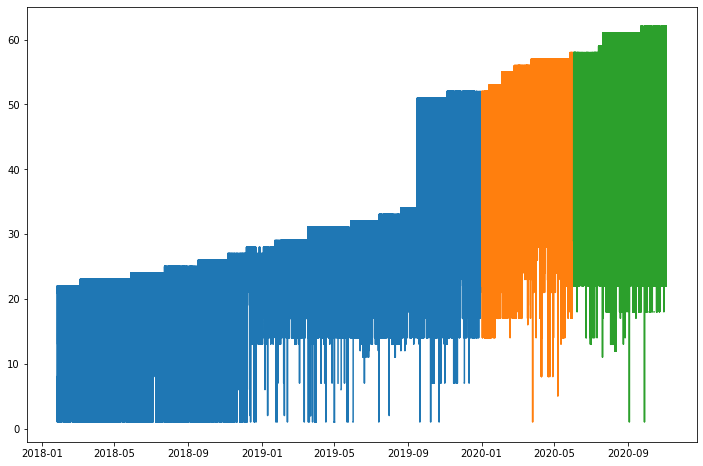

In [30]:
plt.figure(figsize=(12, 8))
plt.plot(train.cohort_id)
plt.plot(validate.cohort_id)
plt.plot(test.cohort_id)
plt.show()

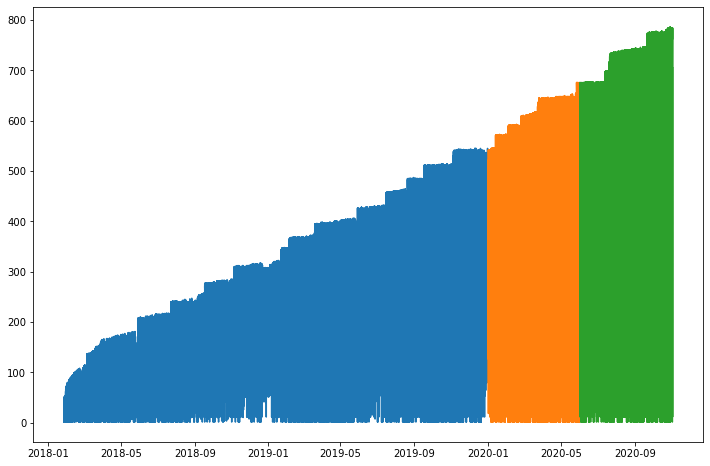

In [31]:
plt.figure(figsize=(12, 8))
plt.plot(train.user_id)
plt.plot(validate.user_id)
plt.plot(test.user_id)
plt.show()

In [32]:
# Calculating the short-window simple moving average
short_rolling = train.rolling(window=12).mean()

# Calculating the long-window simple moving average
long_rolling = train.rolling(window=24).mean()
short_rolling

,user_id,cohort_id
date,,
2018-01-26 09:55:03,NaN,NaN
2018-01-26 09:56:02,NaN,NaN
2018-01-26 09:56:05,NaN,NaN
2018-01-26 09:56:06,NaN,NaN
2018-01-26 09:56:24,NaN,NaN
...,...,...
2019-12-31 15:44:41,451.833333,31.666667
2019-12-31 15:44:41,454.500000,31.166667
2019-12-31 17:41:42,465.500000,32.583333


### Looking at the pages accessed to see if maybe there is something that stands out

Text(0.5, 1.0, 'Total pages requested per day')

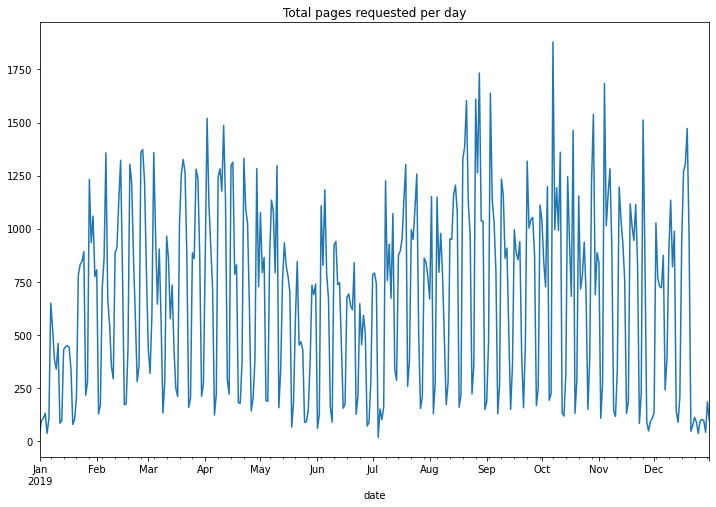

In [33]:
df["2019"].groupby("date").page.count().resample("D").sum().plot.line(figsize=(12, 8))
plt.title("Total pages requested per day")

### Starting over, looking at cohort activity. 

In [34]:
df = df[df.cohort_id == 55]

In [35]:
df.head()

,page,user_id,cohort_id,ip
date,,,,
2020-02-03 15:39:34,login,575,55.0,97.105.19.58
2020-02-03 15:39:35,/,576,55.0,97.105.19.58
2020-02-03 15:39:37,/,577,55.0,97.105.19.58
2020-02-03 15:39:37,login,575,55.0,97.105.19.58
2020-02-03 15:39:43,/,578,55.0,97.105.19.58


In [36]:
df.groupby(['page','ip']).count()

user_id  \
page                                               ip                         
%20https://github.com/RaulCPena                    74.192.167.159         1   
,%20https://github.com/RaulCPena                   74.192.167.159         1   
/                                                  104.190.137.203        5   
                                                   104.5.217.57          50   
                                                   107.136.101.76         1   
...                                                                     ...   
timeseries/sarimax                                 70.112.179.142         2   
timeseries/svr                                     70.112.179.142         1   
timeseries/working-with-time-series-data           70.112.179.142         1   
timeseries/working-with-time-series-data-with-p... 70.112.179.142         1   
                                                   70.130.127.113         1   

                                                                    cohort_id  
page                                               ip                          
%20https://github.com/RaulCPena                    74.192.167.159           1  
,%20https://github.com/RaulCPena                   74.192.167.159           1  
/                                                  104.190.137.203          5  
                                                   104.5.217.57            50  
                                                   107.136.101.76           1  
...                                                                       ...  
timeseries/sarimax                                 70.112.179.142           2  
timeseries/svr                                     70.112.179.142           1  
timeseries/working-with-time-series-data           70.112.179.142           1  
timeseries/working-with-time-series-data-with-p... 70.112.179.142           1  
                                                   70.130.127.113           1  

[3972 rows x 2 columns]

In [37]:
id_ip_df = df.groupby(['user_id','ip']).count()

<AxesSubplot:xlabel='ip', ylabel='user_id'>

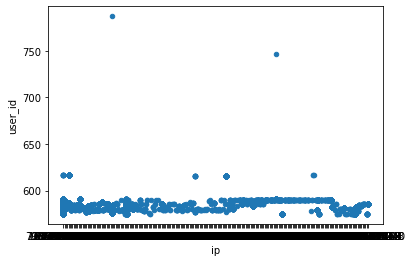

In [38]:
df.plot.scatter('ip','user_id')

In [39]:
def compute_entropy(series):
    counts = series.value_counts()
    if len(counts)==1:
        ent = 0
    else:
        value, counts = np.unique(series, return_counts=True)
        ent = entropy(counts, base=None)
    return ent


In [40]:
compute_entropy(df.ip)

3.1111958906033657

In [41]:
compute_entropy(df.user_id)

2.7988901352084543

# Starting over again

## Goal
- Look for anything out of the norm with our cohort

In [42]:
df = pd.read_csv('anonymized-curriculum-access.txt', sep=" ", header=None)

In [43]:
df['time_stamp'] = df[0] + ' ' + df[1]

In [44]:
df = df.drop(columns = [0,1])

In [45]:
df = df.rename(columns={2: "page", 3:'user_id', 4:'cohort_id', 5:'ip'})

In [46]:
df.head()

,page,user_id,cohort_id,ip,time_stamp
0,/,1,8.0,97.105.19.61,2018-01-26 09:55:03
1,java-ii,1,8.0,97.105.19.61,2018-01-26 09:56:02
2,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018-01-26 09:56:05
3,slides/object_oriented_programming,1,8.0,97.105.19.61,2018-01-26 09:56:06
4,javascript-i/conditionals,2,22.0,97.105.19.61,2018-01-26 09:56:24


In [47]:
df.time_stamp = pd.to_datetime(df.time_stamp)
df = df.set_index('time_stamp')

In [48]:
df['times_accessed'] = 1

In [49]:
# Shows how many times the ciriculum was accessed monthly
df[['times_accessed']].resample('m').sum().head()

,times_accessed
time_stamp,
2018-01-31,3270
2018-02-28,13620
2018-03-31,19548
2018-04-30,14461
2018-05-31,12112


<AxesSubplot:xlabel='time_stamp'>

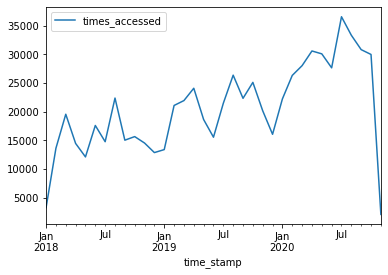

In [50]:
df[['times_accessed']].resample('m').sum().plot()

In [51]:
# How many users are there? Alot of hits with user_id 11, 64 and 53. Maybe apart of codeup??
df['user_id'].value_counts().head()

11     14870
64     14444
53     10874
1       6440
314     6419
Name: user_id, dtype: int64

In [52]:
# Looking at user 11
user11 = df[df.user_id == 11]
user11.ip.value_counts() # Uses a bounch of differnt ip addresses. interesting

97.105.19.58       7049
76.185.145.231     3852
76.185.131.226     2087
97.105.19.61       1459
76.185.142.244      238
76.185.152.58        71
192.171.117.210      37
72.128.136.219       23
72.181.121.84        11
67.164.150.90        11
75.1.201.239          9
99.203.26.55          5
208.54.83.145         4
144.178.1.46          2
75.54.33.188          2
208.54.83.163         2
99.203.155.182        1
99.203.27.231         1
72.205.179.123        1
172.56.15.51          1
208.54.83.234         1
99.203.143.2          1
99.203.26.9           1
99.203.155.78         1
Name: ip, dtype: int64

In [53]:
# Has 2 cohort ids
user11.cohort_id.value_counts()

28.0    12135
1.0      2735
Name: cohort_id, dtype: int64

In [54]:
# Looking at user 64
user64 = df[df.user_id == 64]
user64.ip.value_counts() # Uses a bounch of differnt ip addresses. interesting

97.105.19.58       5690
71.150.217.33      4918
97.105.19.61       1936
12.106.208.194      835
70.118.8.243        628
76.187.118.255      126
76.25.25.4          120
192.171.117.210      56
187.220.23.224       25
209.92.162.135       24
148.244.212.19        9
12.189.101.90         8
24.28.70.46           8
98.6.1.177            6
207.239.160.254       6
127.0.0.1             6
4.16.216.161          5
99.203.31.78          4
201.174.135.51        3
172.58.107.207        3
75.54.33.190          3
24.27.227.1           3
69.148.0.213          3
75.54.33.182          3
69.172.183.120        3
200.68.128.26         2
104.238.45.20         2
187.237.25.33         2
207.87.181.170        2
99.203.22.172         2
187.237.231.85        1
187.237.231.72        1
70.114.21.86          1
Name: ip, dtype: int64

In [55]:
# Has 2 cohort ids. Shares the same cohort ids as user 11 and has id 52 as well
user64.cohort_id.value_counts()

28.0    10627
1.0      3767
52.0       25
Name: cohort_id, dtype: int64

In [56]:
# Looking at user 53
user53 = df[df.user_id == 53]
user53.ip.value_counts() # Not as many ip's as the other 2

97.105.19.58       4895
67.10.174.56       2926
97.105.19.61       2307
67.10.161.55        651
192.171.117.210      36
173.175.82.174       23
173.174.212.111      18
98.6.52.59            5
50.84.218.3           5
72.128.136.219        5
107.77.221.110        2
75.54.33.178          1
Name: ip, dtype: int64

In [57]:
# Has 2 cohort ids. Shares the same cohort id of 28 as user 11 and 64
user53.cohort_id.value_counts()

14.0    8197
28.0    2677
Name: cohort_id, dtype: int64

In [58]:
# Which cohort id has the highest counts of accessing? Not supprising 28 is the most since the users above used
# cohort_id 28 the most
df['cohort_id'].value_counts().head()

28.0    60315
33.0    40168
29.0    37548
53.0    36047
24.0    35624
Name: cohort_id, dtype: int64

In [59]:
# Looking at our cohort now
df59 = df[df.cohort_id == 59]
df59.head()

,page,user_id,cohort_id,ip,times_accessed
time_stamp,,,,,
2020-07-13 14:34:44,/,678,59.0,76.201.20.193,1
2020-07-13 14:37:22,/,679,59.0,24.28.146.155,1
2020-07-13 14:38:28,/,680,59.0,136.50.56.155,1
2020-07-13 14:39:21,13-advanced-topics/1-tidy-data,679,59.0,24.28.146.155,1
2020-07-13 14:39:36,1-fundamentals/1.1-intro-to-data-science,679,59.0,24.28.146.155,1


In [60]:
# Date range of our cohort so far
print(df59.index.min())
print(df59.index.max())

2020-07-13 14:34:44
2020-11-02 15:52:23


In [61]:
# Computing entropy
def compute_entropy(series):
    counts = series.value_counts()
    if len(counts)==1:
        ent = 0
    else:
        value, counts = np.unique(series, return_counts=True)
        ent = entropy(counts, base=None)
    return ent

In [62]:
# entropy of cohort id
compute_entropy(df59.cohort_id) # no entropy as only one unique value is in this column.

0

In [63]:
# entropy of user id
compute_entropy(df59.user_id) 

3.0193491002050257

In [64]:
# entropy of ip
compute_entropy(df59.ip)

3.4316749297604687

In [65]:
# entropy of page
compute_entropy(df59.page)

4.770190297987762

# Resampling by hour

In [66]:
df59.resample('H').user_id.count()

time_stamp
2020-07-13 14:00:00    95
2020-07-13 15:00:00    36
2020-07-13 16:00:00     0
2020-07-13 17:00:00     3
2020-07-13 18:00:00     3
                       ..
2020-11-02 11:00:00     5
2020-11-02 12:00:00    11
2020-11-02 13:00:00    14
2020-11-02 14:00:00    10
2020-11-02 15:00:00    32
Freq: H, Name: user_id, Length: 2690, dtype: int64

In [67]:
df59.resample('H').ip.count()

time_stamp
2020-07-13 14:00:00    95
2020-07-13 15:00:00    36
2020-07-13 16:00:00     0
2020-07-13 17:00:00     3
2020-07-13 18:00:00     3
                       ..
2020-11-02 11:00:00     5
2020-11-02 12:00:00    11
2020-11-02 13:00:00    14
2020-11-02 14:00:00    10
2020-11-02 15:00:00    32
Freq: H, Name: ip, Length: 2690, dtype: int64

## all have the same values no matter what column used

# Split into Train/Test

In [68]:
# looking at how many days are here to do the split
days = df59.index.max() - df59.index.min()
days

Timedelta('112 days 01:17:39')

In [69]:
# Creating a variable for start date
hits = df59.resample('H').ip.count()
hits

time_stamp
2020-07-13 14:00:00    95
2020-07-13 15:00:00    36
2020-07-13 16:00:00     0
2020-07-13 17:00:00     3
2020-07-13 18:00:00     3
                       ..
2020-11-02 11:00:00     5
2020-11-02 12:00:00    11
2020-11-02 13:00:00    14
2020-11-02 14:00:00    10
2020-11-02 15:00:00    32
Freq: H, Name: ip, Length: 2690, dtype: int64

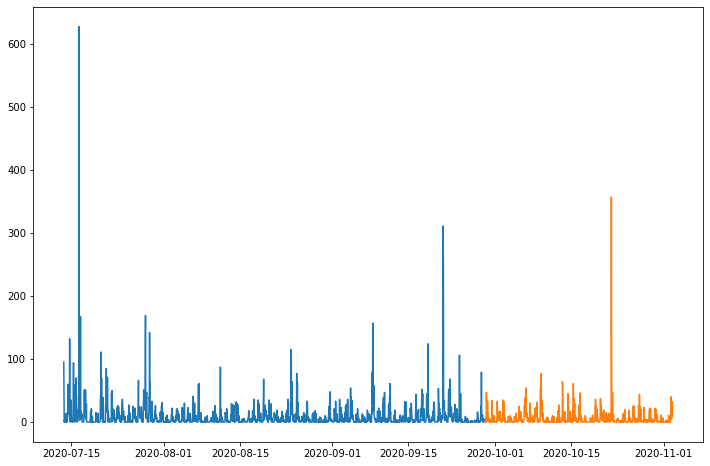

In [70]:
start_date_train = hits.index[0]
end_date_train = '2020-09-28 23:00:00'
start_date_test = '2020-09-29 00:00:00'

train = hits[:end_date_train]
test = hits[start_date_test:]

plt.figure(figsize=(12, 8))
plt.plot(train)
plt.plot(test)
plt.show()

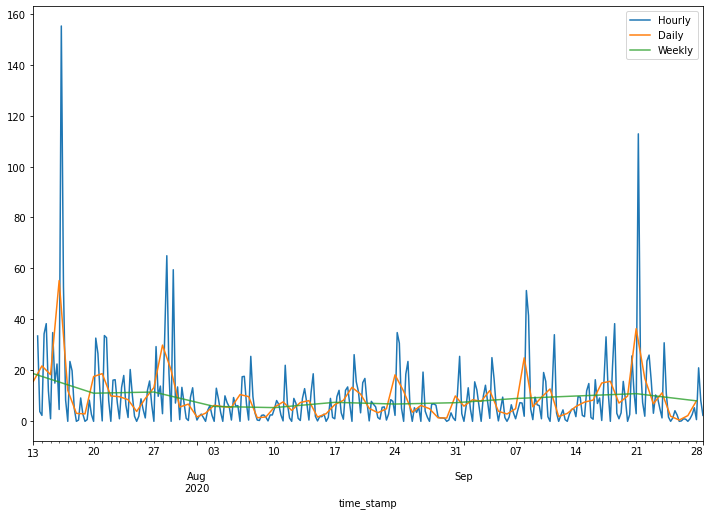

In [71]:
plt.figure(figsize=(12,8))
train.resample('6H').mean().plot(label='Hourly')
train.resample('D').mean().plot(label='Daily')
train.resample('W').mean().plot(alpha=.8, label='Weekly')
plt.legend()

# Simple Moving Average

In [72]:
# short-window simple moving average
short_rolling = train.rolling(window=12).mean()

# long-window simple moving average
long_rolling = train.rolling(window=24).mean()

In [73]:
short_rolling.head(15)

time_stamp
2020-07-13 14:00:00          NaN
2020-07-13 15:00:00          NaN
2020-07-13 16:00:00          NaN
2020-07-13 17:00:00          NaN
2020-07-13 18:00:00          NaN
2020-07-13 19:00:00          NaN
2020-07-13 20:00:00          NaN
2020-07-13 21:00:00          NaN
2020-07-13 22:00:00          NaN
2020-07-13 23:00:00          NaN
2020-07-14 00:00:00          NaN
2020-07-14 01:00:00    14.250000
2020-07-14 02:00:00     6.333333
2020-07-14 03:00:00     3.333333
2020-07-14 04:00:00     3.333333
Freq: H, Name: ip, dtype: float64

In [74]:
long_rolling[20:30]

time_stamp
2020-07-14 10:00:00          NaN
2020-07-14 11:00:00          NaN
2020-07-14 12:00:00          NaN
2020-07-14 13:00:00    16.916667
2020-07-14 14:00:00    13.875000
2020-07-14 15:00:00    12.916667
2020-07-14 16:00:00    18.416667
2020-07-14 17:00:00    19.708333
2020-07-14 18:00:00    19.583333
2020-07-14 19:00:00    19.375000
Freq: H, Name: ip, dtype: float64

Text(0, 0.5, 'hits')

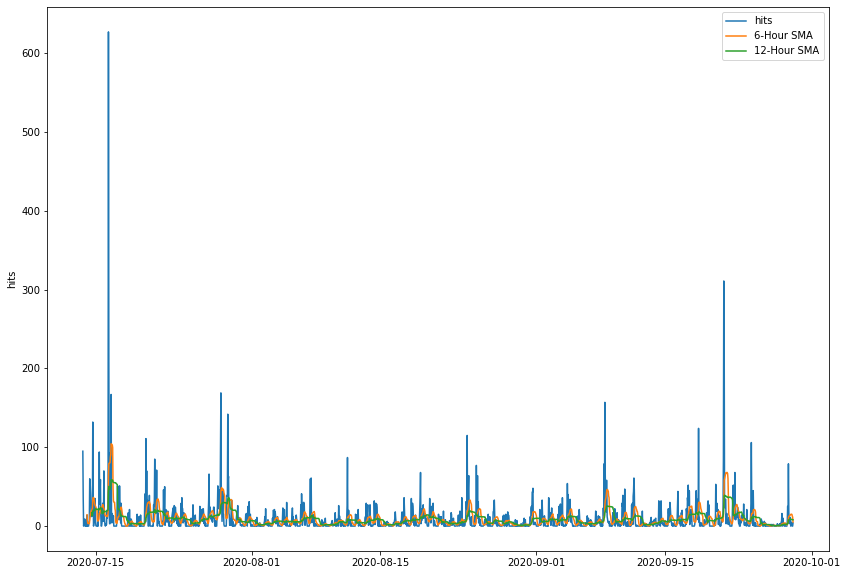

In [75]:
fig, ax = plt.subplots(figsize=(14,10))

ax.plot(train.index, 
        train,
        label='hits')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')

ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')

ax.legend(loc='best')
ax.set_ylabel('hits')
# ax.xaxis.(rotate=90)
# ax.xaxis.set_major_formatter(my_datetime_fmt)

# Expotential Moving Average

In [76]:
ema_short = train.ewm(span=12).mean()
ema_short.head()

time_stamp
2020-07-13 14:00:00    95.000000
2020-07-13 15:00:00    63.041667
2020-07-13 16:00:00    38.436490
2020-07-13 17:00:00    27.250575
2020-07-13 18:00:00    20.661780
Freq: H, Name: ip, dtype: float64

In [77]:
ema_long = train.ewm(span=24).mean()
ema_long.tail()

time_stamp
2020-09-28 19:00:00    8.538561
2020-09-28 20:00:00    8.175476
2020-09-28 21:00:00    7.521438
2020-09-28 22:00:00    6.919723
2020-09-28 23:00:00    6.686145
Freq: H, Name: ip, dtype: float64

Text(0, 0.5, 'hits')

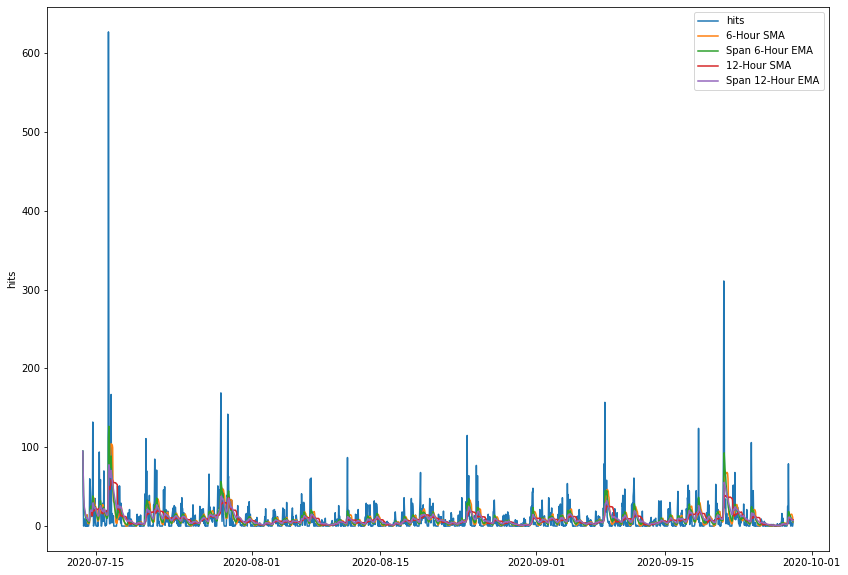

In [78]:
fig, ax = plt.subplots(figsize=(14,10) )

ax.plot(train.index, 
        train,
        label='hits')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        ema_short, 
        label = 'Span 6-Hour EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = 'Span 12-Hour EMA')

ax.legend(loc='best')
ax.set_ylabel('hits')

# Bollinger Bands %B
## Bollinger Bands
- a volatility indicator and commonly used in stock market trading.
- Made up of 3 lines, the Upper Band (UB), the Lower Band (LB) and the Midband. ### Midband
- The Exponential Moving Average
- midband = train.ewm(span=30).mean() ### Upper & Lower Band
- UB/LB = Midband +/- stdev * K
- stdev = train.ewm(span=30).std()
- K = the number of standard deviations to go up and down from the EMA ### %b, Percent Bandwidth
- Shows where the last value sits in relation to the bands
- $\%b = \frac{last-LB}{UB-LB}$
- %b > 1 => point lies above UB
- %b < 0 => point lies below LB
- %b == .5 => point lies on the midband. ### Bandwidth
- The width of the bands
- $Bandwidth = \frac{(UB-LB)}{Midband}$

In [79]:
# Set the window span
span = 24

# compute midband
midband = train.ewm(span=span).mean()
midband

time_stamp
2020-07-13 14:00:00    95.000000
2020-07-13 15:00:00    64.270833
2020-07-13 16:00:00    41.038172
2020-07-13 17:00:00    30.308348
2020-07-13 18:00:00    23.900165
                         ...    
2020-09-28 19:00:00     8.538561
2020-09-28 20:00:00     8.175476
2020-09-28 21:00:00     7.521438
2020-09-28 22:00:00     6.919723
2020-09-28 23:00:00     6.686145
Freq: H, Name: ip, Length: 1858, dtype: float64

In [80]:
# compute exponential stdev
stdev = train.ewm(span=span).std()
stdev

time_stamp
2020-07-13 14:00:00          NaN
2020-07-13 15:00:00    41.719300
2020-07-13 16:00:00    47.617694
2020-07-13 17:00:00    42.890845
2020-07-13 18:00:00    38.583669
                         ...    
2020-09-28 19:00:00    16.281309
2020-09-28 20:00:00    15.667051
2020-09-28 21:00:00    15.197143
2020-09-28 22:00:00    14.724865
2020-09-28 23:00:00    14.146753
Freq: H, Name: ip, Length: 1858, dtype: float64

In [81]:
# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3

ub

time_stamp
2020-07-13 14:00:00           NaN
2020-07-13 15:00:00    189.428734
2020-07-13 16:00:00    183.891254
2020-07-13 17:00:00    158.980884
2020-07-13 18:00:00    139.651171
                          ...    
2020-09-28 19:00:00     57.382487
2020-09-28 20:00:00     55.176630
2020-09-28 21:00:00     53.112868
2020-09-28 22:00:00     51.094318
2020-09-28 23:00:00     49.126404
Freq: H, Name: ip, Length: 1858, dtype: float64

Text(0, 0.5, 'hits')

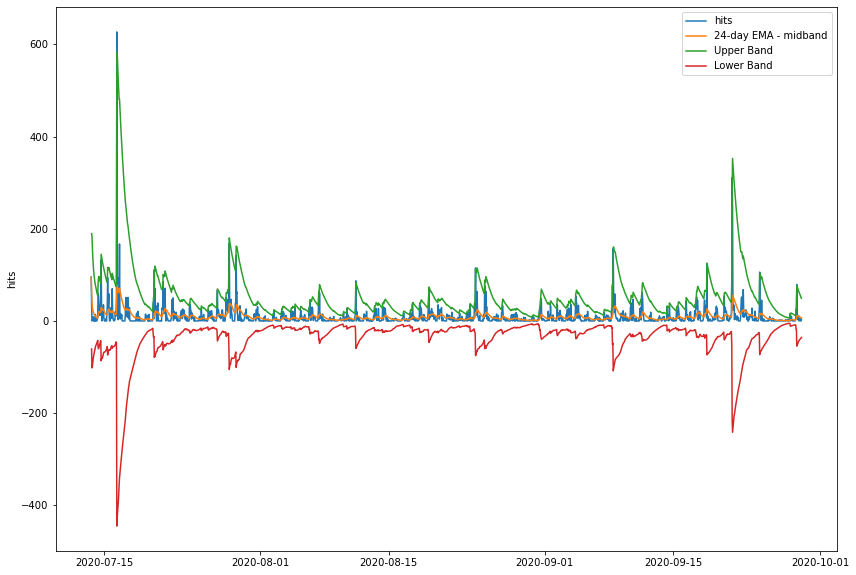

In [82]:
fig, ax = plt.subplots(figsize = (14,10))

ax.plot(train.index, 
        train,
        label='hits')

ax.plot(train.index, 
        midband, 
        label = '24-day EMA - midband')
ax.plot(train.index, 
        ub, 
        label = 'Upper Band')
ax.plot(train.index, 
        lb, 
        label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('hits')

## Where do you think we will have a %b > 1?
- Compute %b
- $\%b = \frac{last-LB}{UB-LB}$

In [83]:
train = pd.concat([train, midband, ub, lb], axis=1)
train.columns = ['hits', 'midband', 'ub', 'lb']
train.head()

,hits,midband,ub,lb
time_stamp,,,,
2020-07-13 14:00:00,95,95.000000,NaN,NaN
2020-07-13 15:00:00,36,64.270833,189.428734,-60.887067
2020-07-13 16:00:00,0,41.038172,183.891254,-101.814909
2020-07-13 17:00:00,3,30.308348,158.980884,-98.364188
2020-07-13 18:00:00,3,23.900165,139.651171,-91.850841


In [84]:
train['pct_b'] = (train['hits'] - train['lb'])/(train['ub'] - train['lb'])

In [85]:
train.head()

,hits,midband,ub,lb,pct_b
time_stamp,,,,,
2020-07-13 14:00:00,95,95.000000,NaN,NaN,NaN
2020-07-13 15:00:00,36,64.270833,189.428734,-60.887067,0.387059
2020-07-13 16:00:00,0,41.038172,183.891254,-101.814909,0.356362
2020-07-13 17:00:00,3,30.308348,158.980884,-98.364188,0.393884
2020-07-13 18:00:00,3,23.900165,139.651171,-91.850841,0.409719


In [86]:
train[train['pct_b']>1]

,hits,midband,ub,lb,pct_b
time_stamp,,,,,
2020-07-16 09:00:00,627,66.340771,577.716188,-445.034645,1.048188
2020-07-20 11:00:00,111,15.851134,110.598602,-78.896333,1.002118
2020-08-11 10:00:00,87,11.926708,83.401089,-59.547673,1.025176
2020-08-24 11:00:00,115,18.310511,112.044224,-75.423203,1.015767
2020-09-08 09:00:00,79,12.384795,75.819877,-51.050287,1.025066
2020-09-14 08:00:00,32,5.216640,31.948481,-21.515200,1.000964
2020-09-21 10:00:00,311,39.240564,293.654278,-215.173150,1.034090
2020-09-24 10:00:00,106,15.501522,104.016686,-73.013642,1.011203
2020-09-28 11:00:00,79,10.778169,76.253119,-54.696780,1.020977
